In [1]:
#Date 27/ 03/ 2021
#We are going to do is first EPR sharing and then the shaired pair measurement by a third party

In [2]:
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plotter
import numpy as np
from IPython.display import display, Math, Latex, Image
%matplotlib inline

In [3]:
#number of pair of epr pairs each have
num_pair = 4

#here alice_epr and bob_epr are a random array of 0 and 1
#0 means that pair should be made |psi+> and 1 means |pis->
alice_epr = np.random.randint(2, size = num_pair)
bob_epr = np.random.randint(2, size = num_pair)

alice_qubits = QuantumRegister(2*num_pair, 'alice')
bob_qubits = QuantumRegister(2*num_pair, 'bob')
charlie = ClassicalRegister(4*num_pair, 'charlie')

print("alice epr " + str(alice_epr))
print("bob epr " + str(bob_epr))

alice epr [0 0 1 0]
bob epr [0 0 0 0]


In [4]:
#here this is the function to encode qubit indexed a and b of circuit in psi_plus or psi_minus respectively

def encode_psi_plus(circuit, a, b):
    circuit.h(a)
    circuit.x(b)
    circuit.cx(a, b)
    return circuit

def encode_psi_minus(circuit, a, b):
    circuit.x([a,b])
    circuit.h(a)
    circuit.cx(a, b)
    return circuit

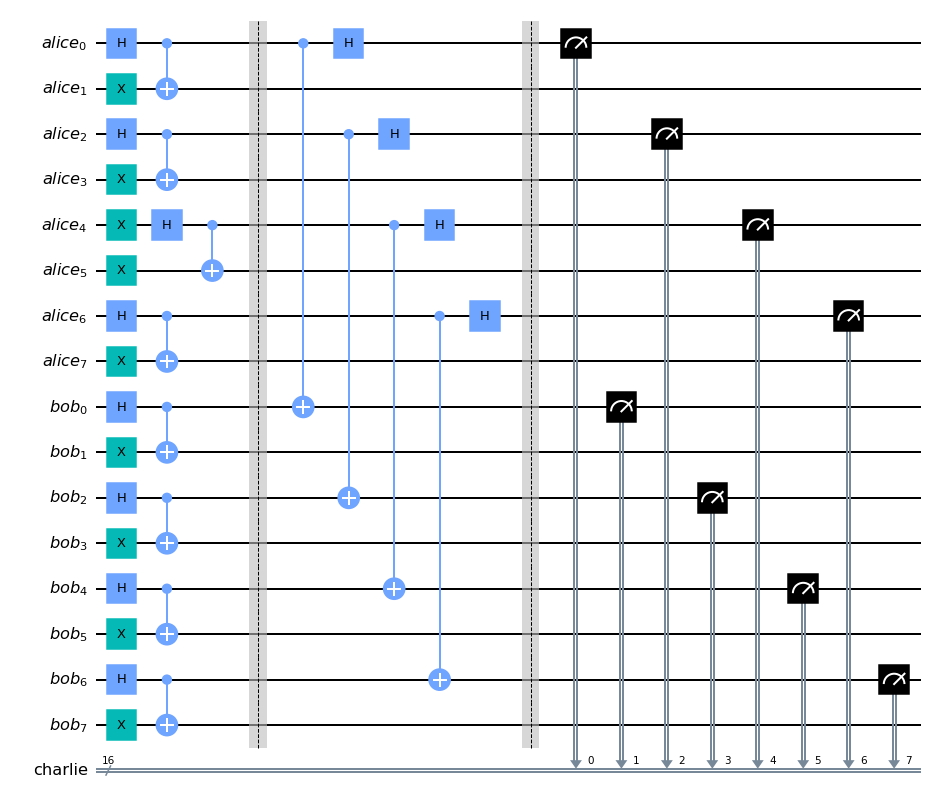

In [5]:
circuit = QuantumCircuit(alice_qubits, bob_qubits, charlie)

for i in range(0, 2*num_pair, 2): 
    j = i//2
    #print(j)
    if alice_epr[j] == 0:
        circuit = encode_psi_plus(circuit, alice_qubits[i], alice_qubits[i+1])
    elif alice_epr[j] == 1:
        circuit = encode_psi_minus(circuit, alice_qubits[i], alice_qubits[i+1])
        
    if bob_epr[j] == 0:
        circuit = encode_psi_plus(circuit, bob_qubits[i], bob_qubits[i+1])
    elif bob_epr[j] == 1:
        circuit = encode_psi_minus(circuit, bob_qubits[i], bob_qubits[i+1])
    
# the EPR encoding is done now
circuit.barrier()

#now Charlie will measure one qubit from each pair from both of them
for i in range(0, 2*num_pair, 2):
    
    j = i//2
    #to measure in bell basis
    circuit.cx(alice_qubits[i], bob_qubits[i])
    circuit.h(alice_qubits[i])
    
circuit.barrier()

for i in range(0, 2*num_pair, 2):
    
    circuit.measure([alice_qubits[i], bob_qubits[i]], [i, i+1])


circuit.draw(output = 'mpl')

In [6]:
def run_circuit(qc2):
    backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
    result = execute(qc2, backend, shots = 2000).result() # we run the simulation
    counts = result.get_counts() # we get the counts
    return counts

def one_shot_result(qc):
    backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
    result = execute(qc, backend, shots = 1).result() # we run the simulation
    counts = result.get_counts() # we get the counts
    return counts

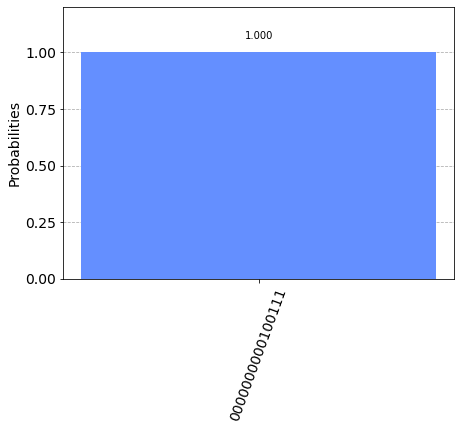

In [7]:
#here this is the result of one shot experiment 

counts = one_shot_result(circuit)
plot_histogram(counts)

In [8]:
r = counts.items()
for res, shots in r:
    result = str(res)
print(result)
#these results are in simple Z basis

0000000000100111


In [9]:
# added in 31/03/2021
##Message Encoding step

#now first generating a randomn message string
#bit lenght will be 2 for each qubit as we are going to use a kind of dense coding

message = np.random.randint(2, size = 2*num_pair)

#first convert all the senders qubit that is of alice into psi_minus by using sigma_z operation

circuit.barrier()

for i in range(1, 2*num_pair, 2):
    if alice_epr[i//2] == 0:
        circuit.z(alice_qubits[i])

circuit.barrier()

#now all senders qubit are converted to psi_minus now we will Encode our message
print("The initial message is : " + str(message))

The initial message is : [1 1 1 0 0 0 1 1]


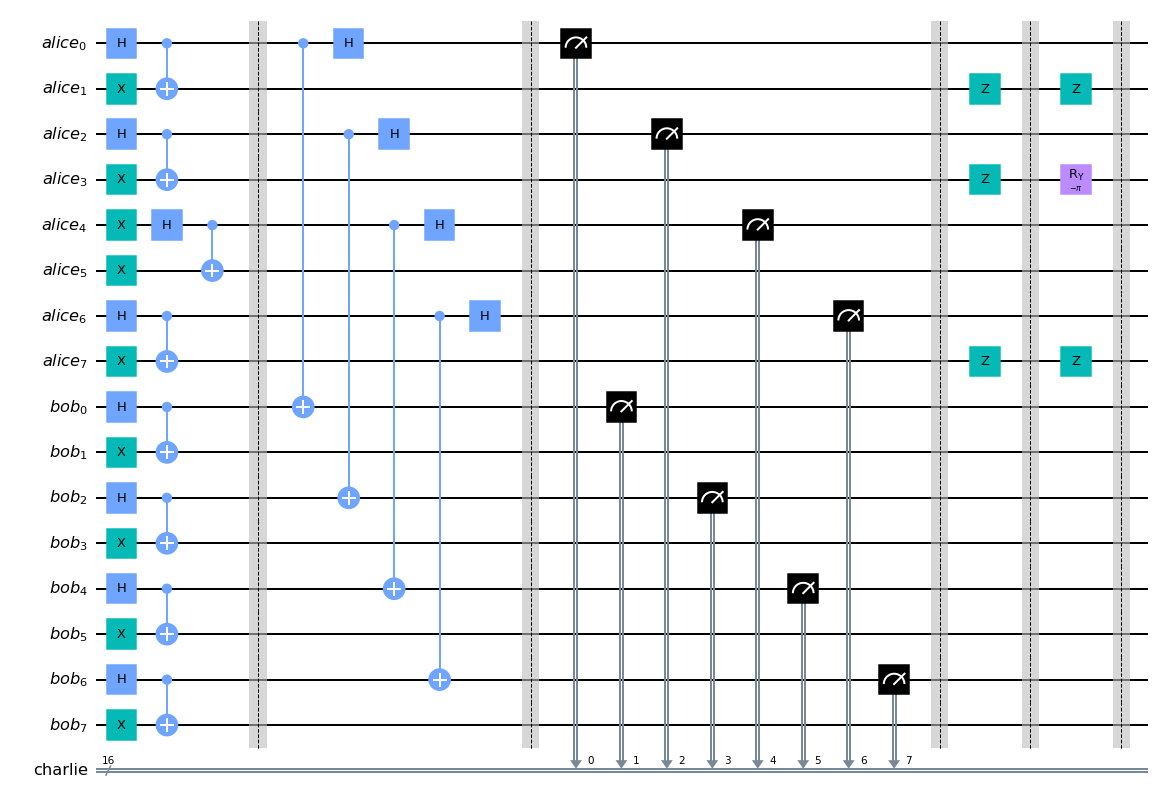

In [10]:
#now dense coding the qubits according to our message

#changes has to be done 

for i in range(0, 2*num_pair, 2):
    j = i//2
    if message[i] == 0 and message[i+1] == 0:
        continue
    elif message[i] == 0 and message[i+1] == 1:
        circuit.x(alice_qubits[i+1])
    elif message[i] == 1 and message[i+1] == 0:
        circuit.ry(-np.pi, alice_qubits[i+1])
    elif message[i] == 1 and message[i+1] == 1:
        circuit.z(alice_qubits[i+1])

circuit.barrier()
circuit.draw(output = 'mpl')

#can be used for security check by randomly inserting sigma_z or I in bob qubits

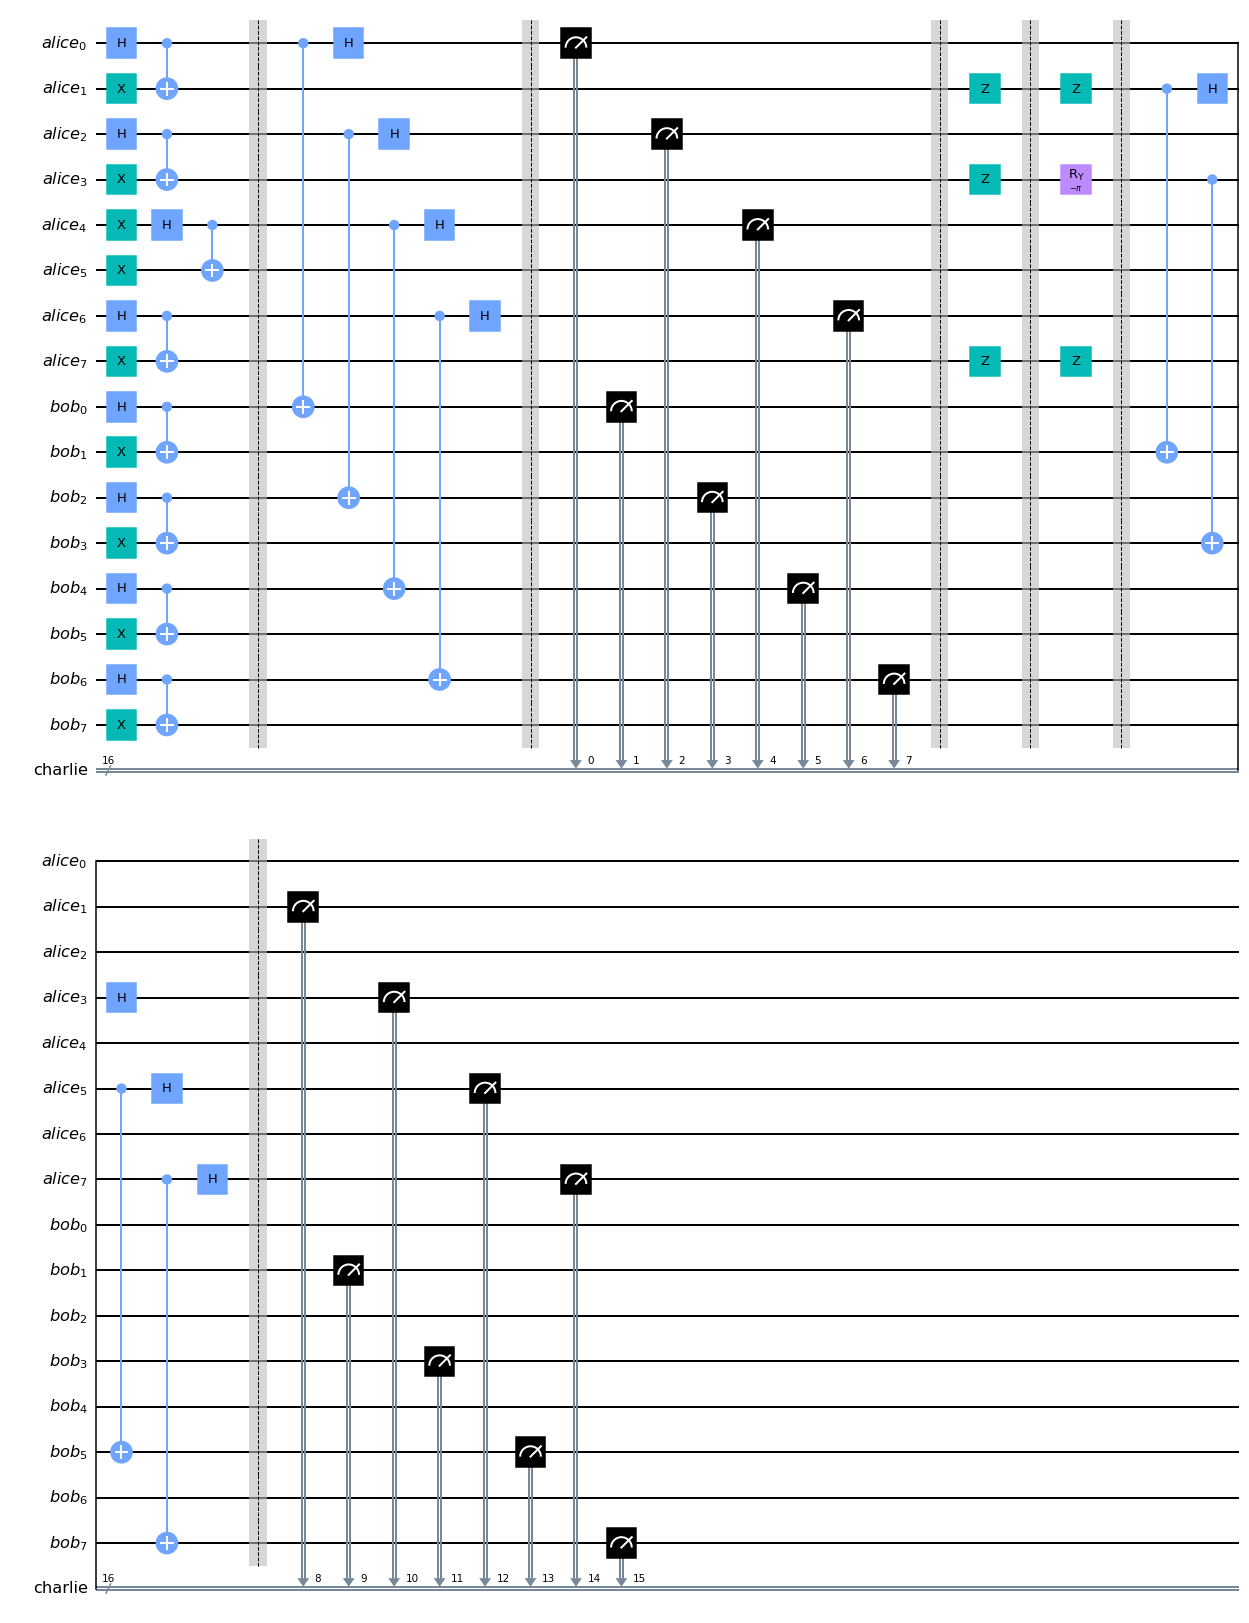

In [11]:
# now dense coding is done now the measurement part is done by a third person charlie to complete the MDI-QSDC protocol

for i in range(1, 2*num_pair, 2):
    
    #using bell basis for measurement
    circuit.cx(alice_qubits[i], bob_qubits[i])
    circuit.h(alice_qubits[i])

circuit.barrier()
k = 2*num_pair
for i in range(1, 2*num_pair, 2):
    
    circuit.measure([alice_qubits[i], bob_qubits[i]], [k+i-1,k+i])
    
circuit.draw(output = 'mpl')

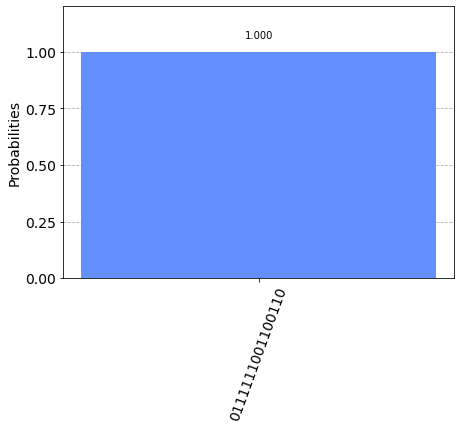

In [12]:
final_count = one_shot_result(circuit)
plot_histogram(final_count)

In [13]:
r = final_count.items()
for res, shots in r:
    result2 = str(res)
print(result2)

0111111001100110


In [14]:
first = result2[2*num_pair:4*num_pair]
second = result2[0:2*num_pair]
first = first[::-1]
second = second[::-1]
print(first)
print(second)

01100110
01111110


Now Our Coding Part Has been done we have to decode the message 
For that we have to consider some assumptions here:
1. Single Qubits has not been introduced yet
2. Sigma_Z operation have not been done yet by BOB

Now to decode the message we look at the following picture
![title](img1.png)

Now Bob knows the Bases of Alice as they are all Psi_Minus 
so Bob just need to compare the
first Result and second result calculate in upper cell
<br>
Now we just need to compare these result with the table given in the 
research paper pdf

In [23]:
#Now bob bases are know as bob_epr
#Here bp is bit flip and pp is phase flip
decoded = []
for i in range(0, 2*num_pair, 2):
    
    bob_base = bob_epr[i//2]
    
    f = first[i:i+2]
    s = second[i:i+2]
    bp = 0
    pp = 0
    
    if f[0] != s[0]:
        bp = 1
    if f[1] != s[1]:
        pp = 1
    if bob_base == 0:
        bp = 1 - bp
    
    print(f, s, bp, pp, bob_base)
    
    if bp == 0 and pp == 0:
        decoded.append('0')
        decoded.append('0')
    elif bp == 0 and pp == 1:
        decoded.append('0')
        decoded.append('1')
    elif bp == 1 and pp == 0:
        decoded.append('1')
        decoded.append('1')
    else:
        decoded.append('1')
        decoded.append('0')
    
print(decoded)
print(message)

01 01 1 0 0
10 11 1 1 0
01 11 0 0 0
10 10 1 0 0
['1', '1', '1', '0', '0', '0', '1', '1']
[1 1 1 0 0 0 1 1]


In [ ]:
#Comparing the messages
for i in range(len(message)):
    flag = 1
    if int(decoded[i]) != message[i]:
        print("Wrong Output")
        flag = 0
        break
if f